                 Model  Accuracy  Precision    Recall  F1-score       AUC
0                  KNN  0.895606   0.578341  0.270474  0.368576  0.727211
1  Logistic Regression  0.811726   0.330614  0.655172  0.439465  0.795617
2        Decision Tree  0.902282   0.668493  0.262931  0.377417  0.792321
3                  SVM  0.836368   0.367424  0.627155  0.463376  0.785998


<ipython-input-2-4d341238efc1>:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["y"], palette="coolwarm")


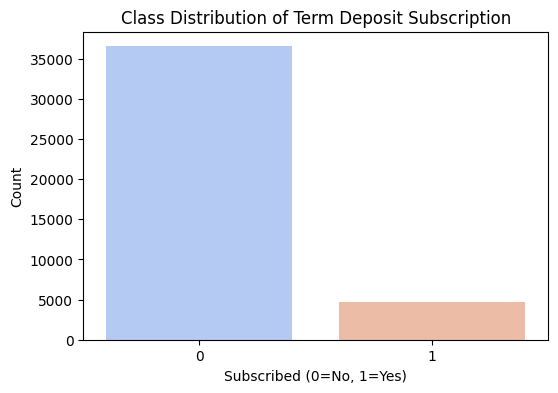

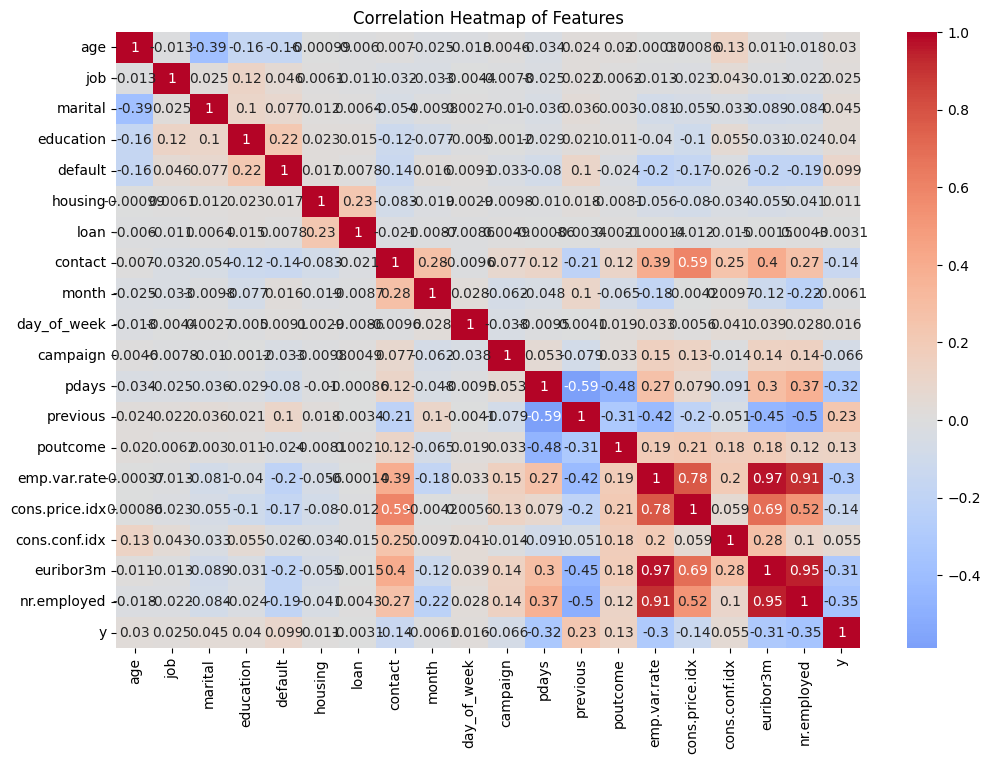

<ipython-input-2-4d341238efc1>:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")


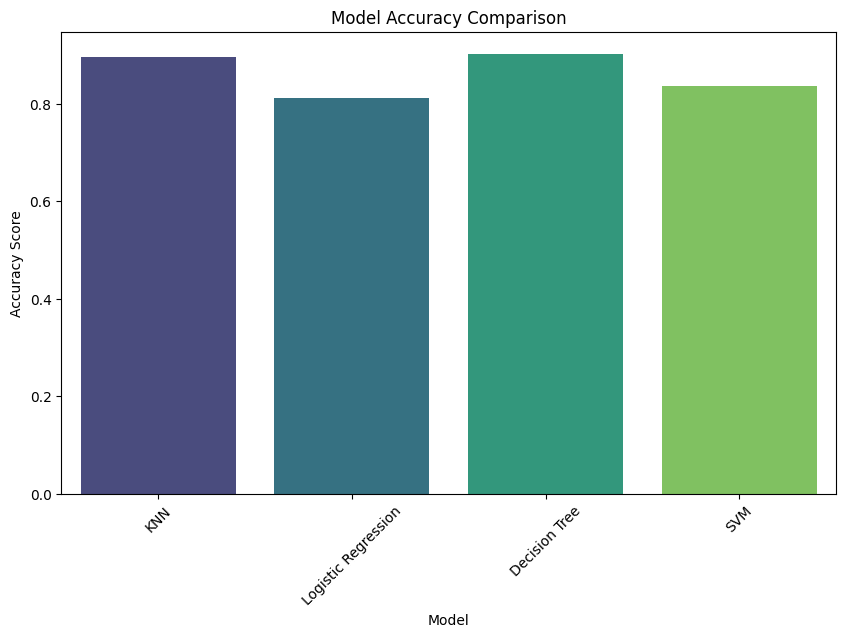

<ipython-input-2-4d341238efc1>:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="F1-score", data=results_df, palette="magma")


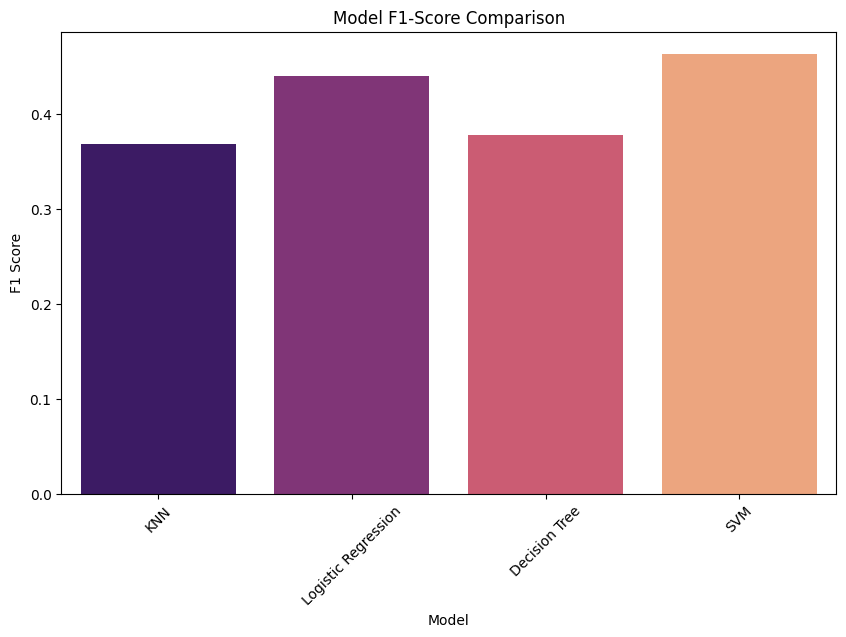

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Check available file paths
possible_paths = [
    "/mnt/data/bank-additional-full.csv",
    "/content/sample_data/bank-additional-full.csv"
]

file_path_full = None
for path in possible_paths:
    if os.path.exists(path):
        file_path_full = path
        break

if file_path_full is None:
    raise FileNotFoundError("Le fichier bank-additional-full.csv est introuvable. Vérifiez son emplacement.")

# Load dataset
df = pd.read_csv(file_path_full, sep=";")

# Data Cleaning and Preprocessing
# Replace "unknown" with NaN
df.replace("unknown", pd.NA, inplace=True)

# Encode categorical variables
label_encoders = {}
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != "y":
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

# Convert target variable to binary
df["y"] = df["y"].map({"no": 0, "yes": 1})

# Drop "duration" as it should not be used for realistic predictions
df.drop(columns=["duration"], inplace=True)

# Normalize numerical variables
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.difference(["y"])
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Split dataset into training and test sets
X = df.drop(columns=["y"])
y = df["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize models
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "SVM": SVC(kernel="linear", class_weight="balanced", probability=True)
}

# Train and evaluate models
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    results.append({"Model": name, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-score": f1, "AUC": auc})

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Save results
results_df.to_csv("model_results.csv", index=False)

# Plot class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df["y"], palette="coolwarm")
plt.title("Class Distribution of Term Deposit Subscription")
plt.xlabel("Subscribed (0=No, 1=Yes)")
plt.ylabel("Count")
plt.savefig("class_distribution.png")
plt.show()

# Plot correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Features")
plt.savefig("correlation_heatmap.png")
plt.show()

# Plot model performance
plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy Score")
plt.xticks(rotation=45)
plt.savefig("model_accuracy.png")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="F1-score", data=results_df, palette="magma")
plt.title("Model F1-Score Comparison")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.savefig("model_f1score.png")
plt.show()
